In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from tqdm import tqdm_notebook as tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader

from torch.utils.data import Dataset

In [4]:
from sklearn.utils import shuffle
from scipy.special import softmax

In [5]:
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [6]:
class TorchDataset(Dataset):
    def __init__(self, X, Y, device = 'cpu'):
        super(TorchDataset, self).__init__()
        self.X = torch.FloatTensor(X).to(device)
        self.Y = torch.FloatTensor(Y).to(device)
        self.len = X.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.Y[index]

In [7]:
class HyperModelNN(nn.Module):
    def __init__(self, input_dim = 20, hidden_dim = 10, output_dim = 10, device = 'cpu'):
        super(HyperModelNN, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.device = device
        
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        
        self.optimizer = torch.optim.Adam(self.parameters())
        
        self.to(device)
        
    def forward(self, input):
        out = input
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        return out
    
    def E_step(self, X, Y, Z, HyperParameters):
        pass
    
    def M_step(self, X, Y, Z, HyperParameters):
        dataset = TorchDataset(X, Z, device = self.device)
        
        for _ in range(10):
            train_generator = DataLoader(dataset = dataset, batch_size = 16, shuffle=True)
            for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
                self.zero_grad()
                loss = -(torch.nn.functional.log_softmax(self.forward(batch_of_x), dim = -1)*batch_of_y).sum()
                loss.backward()
                self.optimizer.step()
        pass
        

In [8]:
class NoiseModelLinear:
    def __init__(self, input_dim = 20, device = 'cpu'):
        self.input_dim = input_dim
        self.device = device
        
        self.W = torch.zeros(input_dim, 1, device = self.device)
        
    def forward(self, input):
        return torch.randn([input.shape[0], 1])
     
    def __call__(self, input):
        return self.forward(input)
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        Parameter is a Key in dictionary
        """
        if Parameter == 'beta':
            temp1 = Y**2
            return (temp1*Z).mean().detach()
    
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp1 = Y**2
        return (-0.5*beta*(temp1) + 0.5*np.log(beta/(2*np.pi))).detach()
        
    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        """
        pass
    
    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        """
        pass

In [523]:
class EachModelLinear:
    def __init__(self, input_dim = 20, device = 'cpu', a = None):
        self.input_dim = input_dim
        self.device = device
        
        self.a = a

        self.W = 10*torch.randn(input_dim, 1, device = self.device)
        self.B = torch.eye(input_dim, device = self.device)

        
    def forward(self, input):
        return input@self.W
    
    def __call__(self, input):
        return self.forward(input)
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        Parameter is a Key in dictionary
        """
        if Parameter == 'beta':
            temp1 = Y**2
            temp2 = -2*Y*(X@self.W)
            temp3 = torch.diagonal(X@(self.B+self.W@self.W.transpose(0,1))@X.transpose(0,1)).view([-1, 1])
            return ((temp1 + temp2 + temp3)*Z).mean().detach()
        
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp1 = Y**2
        temp2 = -2*Y*(X@self.W)
        temp3 = torch.diagonal(X@(self.B+self.W@self.W.transpose(0,1))@X.transpose(0,1)).view([-1, 1])
        return (-0.5*beta*(temp1 + temp2 + temp3) + 0.5*np.log(beta/(2*np.pi))).detach()
        

    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp = X.unsqueeze(2)
        if self.a is None:
            self.B = torch.inverse(((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = (X*Y*Z).sum(dim = 0)
            self.W.data = (self.B@second).view_as(self.W).detach()
        else:
            self.B = torch.inverse(torch.diag(1/self.a) + beta*((temp*Z.unsqueeze(1))@temp.transpose(2, 1)).sum(dim = 0)).detach()
            second = (X*Y*Z).sum(dim = 0)
            self.W.data = beta*(self.B@second).view_as(self.W).detach()
        return

    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        if self.a is not None:
            self.a = torch.diagonal(self.B+self.W@self.W.transpose(0,1)).detach()
        return


In [524]:
class NoiseModelKhi:
    def __init__(self, input_dim = 20, device = 'cpu'):
        self.input_dim = input_dim
        self.device = device
        
        self.W = torch.zeros(input_dim, 1, device = self.device)
        
    def forward(self, input):
        return torch.randn([input.shape[0], 1])
     
    def __call__(self, input):
        return self.forward(input)
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        Parameter is a Key in dictionary
        """
        if Parameter == 'beta':
            temp1 = Y
            return (0.5*temp1*Z).mean().detach()
    
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp1 = Y
        return (-0.5*beta*(temp1) + np.log(0.5*beta)).detach()
        
    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        """
        pass
    
    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        """
        pass

In [525]:
class EachModelKhi:
    def __init__(self, input_dim = 20, device = 'cpu', a = None):
        self.input_dim = input_dim
        self.device = device
        
        if a is not None:
            self.a = a
        else:
            self.a = np.ones(input_dim)

        self.W = torch.randn(input_dim, 1, device = self.device)

        
    def forward(self, input):
        return input@self.W
    
    def __call__(self, input):
        return self.forward(input)
    
    def OptimizeHyperParameters(self, X, Y, Z, HyperParameters, Parameter):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        Parameter is a Key in dictionary
        """
        if Parameter == 'beta':
            temp1 = Y
            temp2 = -(X@self.W)
            return (0.5*(temp1 + temp2)*Z).mean().detach()
        
    def LogLikeLihoodExpectation(self, X, Y, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp1 = Y
        temp2 = -(X@self.W)
        return (-0.5*beta*(temp1 + temp2) + np.log(0.5*beta)).detach()
        

    def E_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        beta = 1./(HyperParameters['beta'] + 0.000001)
        temp = X.unsqueeze(2)
        
        second = (X*Z).sum(dim = 0)
        self.W.data = 0.5*beta*(self.a*second).view_as(self.W).detach()
        
        return

    def M_step(self, X, Y, Z, HyperParameters):
        """
        X is a tensor of shape [N x n]
        Y is a tensor of shape [N x 1]
        Z is a tensor of shape [N x 1]
        HyperParameters is a dictionary
        """
        if self.a is not None:
            self.a = torch.diagonal(torch.diag(self.a)+self.W@self.W.transpose(0,1)).detach()
        return
        

In [526]:
class MixtureExpert:
    def __init__(self, input_dim = 10, K = 2, HyperParameters = {'beta': 1}, HyperModel = None, ListOfModels = None, device = 'cpu'):
        """
        It's necessary! The Hyper Parameter should be additive to models.
        """
        
        self.K = K
        self.n = input_dim
        self.device = device
        
        self.HyperParameters = HyperParameters
        
        if HyperModel is None:
            self.HyperModel = HyperModelNN(input_dim = input_dim, hidden_dim = 10, output_dim = K, device = device)
        else:
            self.HyperModel = HyperModel
            
        if ListOfModels is None:
            self.ListOfModels = [EachModelLinear(input_dim = input_dim, device = device) for _ in range(K)]
        else:
            self.ListOfModels = ListOfModels
        
        self.pZ = None
        return
        
    def E_step(self, X, Y):
# Optimize Z
        temp1 = torch.nn.functional.log_softmax(self.HyperModel(X), dim = -1)
        temp2 = torch.cat([self.ListOfModels[k].LogLikeLihoodExpectation(X, Y, self.HyperParameters) for k in range(self.K)], dim = 1)
        self.pZ = torch.nn.functional.softmax(temp1 + temp2, dim=-1).detach()
    
# Optimize each model
        for k in range(self.K):
            self.ListOfModels[k].E_step(X, Y, self.pZ[:,k].view([-1, 1]), self.HyperParameters)
            
# Optimize HyperModel
        self.HyperModel.E_step(X, Y, self.pZ, self.HyperParameters)
        return
        
    def M_step(self, X, Y):
# Optimize EachModel
        for k in range(self.K):
            self.ListOfModels[k].M_step(X, Y, self.pZ[:, k].view([-1, 1]), self.HyperParameters)
            
# Optimize HyperParameters
        for Parameter in self.HyperParameters:
            temp = 0
            for k in range(self.K):
                temp += self.ListOfModels[k].OptimizeHyperParameters(X, Y, self.pZ[:, k].view([-1, 1]), self.HyperParameters, Parameter)
            self.HyperParameters[Parameter] = temp.detach()
        
# Optimize HyperModel
        self.HyperModel.M_step(X, Y, self.pZ, self.HyperParameters)
        return
                
    def fit(self, X = None, Y = None, epoch = 10, progress = None):
        """
        X has a shape [N x n]
        Y has a shape [n x p]
        """
        if X is None:
            return None
        if y is None:
            return None
        
        iterations = range(epoch)
        
        if progress is not None:
            iterations = progress(iterations)
        
        for _ in iterations:
            self.E_step(X, Y)
            self.M_step(X, Y)
            
        return
    
    def predict(self, X):
        """
        X has a shape [N x n]
        """
        pi = torch.nn.functional.softmax(self.HyperModel(X), dim = -1).detach()
        answ = torch.cat([self.ListOfModels[k](X) for k in range(self.K)], dim = 1).detach()
        
        return (answ*pi).sum(dim = -1).data.numpy()
    

# Experiment

In [527]:
from PIL import Image

In [528]:
from PIL import ImageDraw

In [529]:
image = Image.fromarray(np.zeros([255, 255], dtype = np.int8))

In [530]:
draw = ImageDraw.Draw(image)

In [531]:
x0, y0, x1, y1 = [20, 20, 230, 230]
draw.ellipse([x0, y0, x1, y1], fill = 1)
draw.ellipse([x0+1, y0+1, x1-1, y1-1], fill = 0)

k = 70
draw.ellipse([x0+k, y0+k, x1-k, y1-k], fill = 1)
draw.ellipse([x0+1+k, y0+1+k, x1-1-k, y1-1-k], fill = 0)

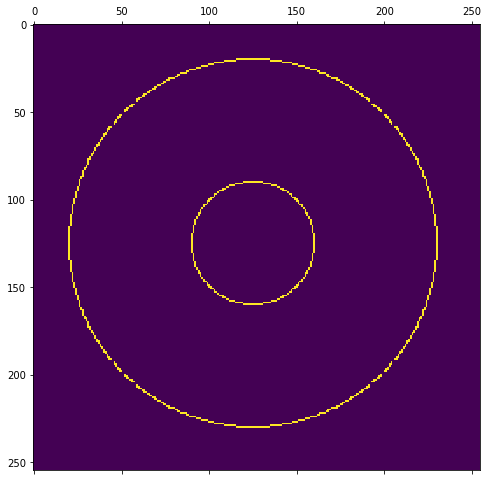

In [532]:
plt.matshow(image)

In [533]:
x = np.where(np.array(image) == 1)[0]
x = x/255
# x = x - x.mean()
y = np.where(np.array(image) == 1)[1]
y = y/255
# y = y - y.mean()

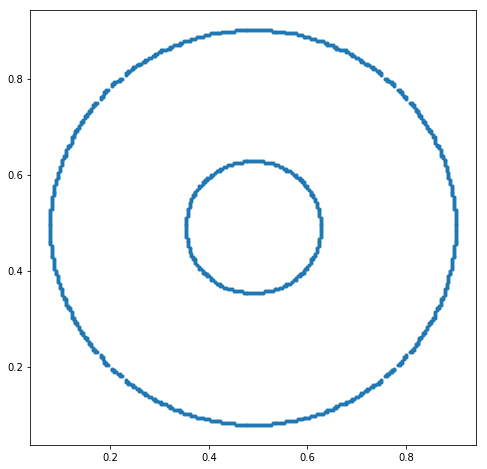

In [534]:
plt.plot(x, y, '.')

In [610]:
N = 50
n = 3
r1 = 3
r2 = 4
phi = np.linspace(0, 2*np.pi, N)

x0 = 5
y0 = 5

# x = np.hstack([r1*np.sin(phi), r2*np.sin(phi), 1*np.random.randn(50)])
x = np.hstack([r1*np.sin(phi), r2*np.sin(phi)])
# x += 0.1*np.random.randn(x.shape[0])
x += x0
# y = np.hstack([r1*np.cos(phi), r2*np.cos(phi), 1*np.random.randn(50)])
y = np.hstack([r1*np.cos(phi), r2*np.cos(phi)])
# y += 0.1*np.random.randn(y.shape[0])
y += y0

X = np.vstack([2*x, 2*y, np.ones_like(x)]).T
Y = x**2+y**2

In [611]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

In [612]:
X_tr.shape, Y_tr.shape


(torch.Size([100, 3]), torch.Size([100, 1]))

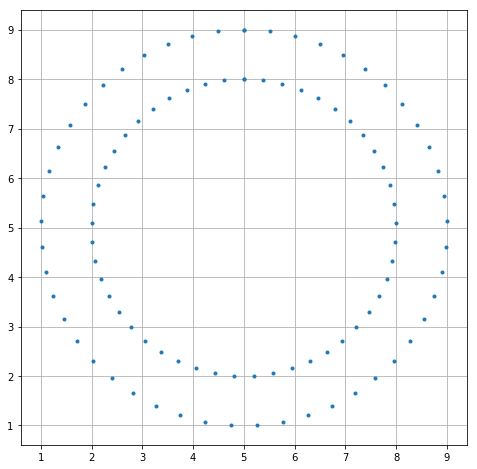

In [613]:
_ = plt.plot(x, y, '.')

plt.grid()
plt.show()

In [614]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [615]:
LIST_A = [torch.Tensor([1, 1, 1]), torch.Tensor([1, 1, 1])]

In [616]:
K = 2
LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device, a = torch.ones(3)*LIST_A[k]))
# K += 1
# LoM.append(NoiseModelLinear(input_dim = n))


HypPar = {'beta': 1}


HpMd = HyperModelNN(input_dim = n, hidden_dim = 3, output_dim = K, device = device)
model = MixtureExpert(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)


In [617]:
print(LoM[0].a)
print(LoM[1].a)

tensor([1., 1., 1.])
tensor([1., 1., 1.])


In [618]:
%%time
model.fit(X_tr, Y_tr, 30, progress = tqdm)


CPU times: user 892 ms, sys: 30.3 ms, total: 923 ms
Wall time: 932 ms


In [619]:
print(LoM[0].a)
print(LoM[1].a)

tensor([  1.5047,   5.4313, 116.1563])
tensor([  24.9810,   25.0090, 1405.6390])


In [620]:
model.HyperParameters

{'beta': tensor(12.6291)}

In [621]:
((model.predict(X_tr)-Y_tr)**2).mean()

tensor(2511.5356)

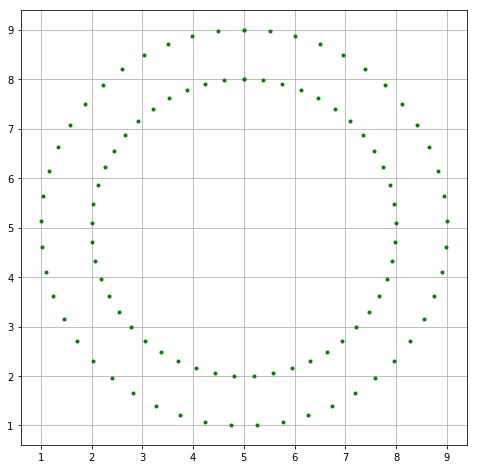

In [622]:
idx = np.argmax(model.pZ.data.numpy(), axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yelow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i])
    
plt.grid()
plt.show()

In [623]:
TEMP = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])

CIRCLE = np.zeros_like(TEMP)

for i, param in enumerate(TEMP):
    x0, y0 = param[:2]
    r = (param[2] - param[1]**2 - param[0]**2)**0.5
    CIRCLE[i] = x0, y0, r
    
CIRCLE

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


array([[4.3020787e-09, 1.4118578e-08, 2.6894920e-04],
       [4.9975829e+00, 5.0004020e+00,           nan]], dtype=float32)

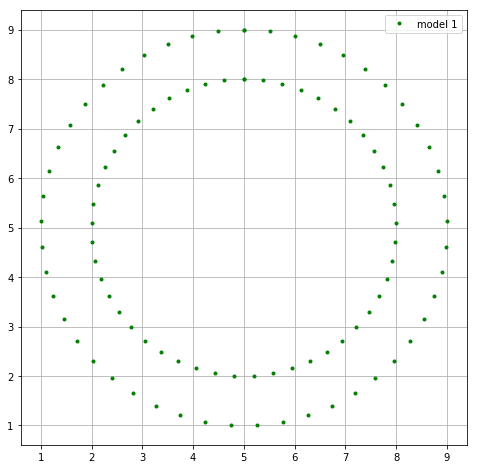

In [624]:
idx = np.argmax(model.pZ.data.numpy(), axis = 1)
t = np.linspace(0, 2*np.pi, 100)

colors = ['orange', 'green', 'red', 'yelow', 'blue']

for i in np.unique(idx):
    _ = plt.plot(x[idx == i], y[idx == i], '.', color = colors[i], label = 'model '+str(i))
    
    x0, y0, r = CIRCLE[i]
    x_plot = x0 + r*np.sin(t)
    y_plot = y0 + r*np.cos(t)
    
    _ = plt.plot(x_plot, y_plot, '-', color = colors[i])
    
plt.grid()

plt.legend(loc = 'best')
plt.show()